# Hyper-parameters tuning on HPC - NZ RSE 2020

This demo illustrates one simple way multiple ways to adapt a random search
strategy for hyper-parameters tuning to use HPC for the many parallel
computations involved.

In this example, we will rely on [Dask](https://dask.org) to do the heavy lifting,
distributing the parallel operations on SLURM jobs.

In [1]:
import json
import warnings
from urllib.parse import urlparse

import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score

import joblib
import dask
from dask.distributed import Client
from dask_jobqueue import SLURMCluster
from dask_ml.model_selection import HyperbandSearchCV

import torch
import skorch

from torch_models import SimpleCNN

Load MNIST data from [OpenML](https://www.openml.org/d/554).

In [2]:
X, y = fetch_openml(
    "mnist_784", version=1, return_X_y=True, parser="pandas", as_frame=False
)
X = X / 255.0
y = y.astype(int)

This dataset contains images of digits. Here is a sample.

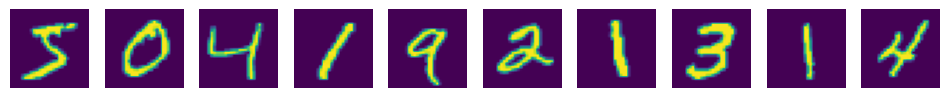

In [3]:
_, axes = plt.subplots(1, 10, figsize=(12, 5))
for ax, digit in zip(axes, X):
    ax.imshow(digit.reshape(28, 28))
    ax.axis("off")

To keep this example code quick, let's use only a subset of the whole data set
as train and test sets.

In [4]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, train_size=5000, test_size=10000, random_state=42
)

Fit a simple multi-layer perceptron neural net.

In [5]:
%%time
mlp = MLPClassifier(random_state=42).fit(X_train, y_train)

CPU times: user 20 s, sys: 8.56 s, total: 28.6 s
Wall time: 16.2 s


In [6]:
y_pred = mlp.predict(X_test)
mlp_acc = accuracy_score(y_test, y_pred)
print(f"Baseline MLP test accuracy is {mlp_acc * 100:.2f}%.")

Baseline MLP test accuracy is 93.70%.


Tune hyper-parameters using a random search strategy.

In [7]:
param_space = {
    "hidden_layer_sizes": st.randint(50, 200),
    "alpha": st.loguniform(1e-5, 1e-2),
    "learning_rate_init": st.loguniform(1e-4, 1e-1),
}
mlp_tuned = RandomizedSearchCV(
    MLPClassifier(random_state=42), param_space, n_iter=10, random_state=42, verbose=1
)

Start a Dask cluster using SLURM jobs as workers.

There are a couple of things we need to configure here:

- disable the mechanism to write on disk when workers run out of memory,
- set memory, CPUs, maximum time and number of workers per SLURM job,
- ensure the network interface is the fast infiniband interface `ib0`,
- set dask folders for log files and workers data.

All of these options can be set in configuration files, see [Dask configuration](https://docs.dask.org/en/latest/configuration.html)
and [Dask jobqueue configuration](https://jobqueue.dask.org/en/latest/configuration-setup.html)
for more information.

In [8]:
dask.config.set(
    {
        "distributed.worker.memory.target": False,  # avoid spilling to disk
        "distributed.worker.memory.spill": False,  # avoid spilling to disk
    }
)

nesi_account = "nesi99999"  # change with your NeSI project account

cluster = SLURMCluster(
    cores=4,
    processes=1,
    memory="4GiB",
    walltime="0-00:10",
    account=nesi_account,
    interface="ib0",
    log_directory="../dask/logs",  # folder for SLURM logs for each worker
    local_directory="../dask",  # folder for workers data
)
client = Client(cluster)

Once the scheduler has started, we can access the dashboard via the Jupyter Server Proxy.

In [9]:
url = urlparse(client.dashboard_link)
print(f"https://jupyter.nesi.org.nz/user-redirect/proxy/{url.port}{url.path}")

https://jupyter.nesi.org.nz/user-redirect/proxy/8787/status


Spawn 10 workers and connect a client to be able use them.

In [10]:
cluster.scale(n=10)
client.wait_for_workers(1)

Scikit-learn uses [Joblib](https://joblib.readthedocs.io) to parallelize
computations of many operations, including the randomized search on
hyper-parameters. If we configure Joblib to use Dask as a backend,
computations will be automatically scheduled and distributed on nodes of the
HPC platform.

In [11]:
%%time
with joblib.parallel_backend("dask", scatter=[X_train, y_train]):
    mlp_tuned.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
CPU times: user 11 s, sys: 4.41 s, total: 15.4 s
Wall time: 1min 23s


Enjoy an optimized model :).

In [12]:
y_pred_tuned = mlp_tuned.predict(X_test)
mlp_tuned_acc = accuracy_score(y_test, y_pred_tuned)
print(f"Tuned MLP test accuracy is {mlp_tuned_acc * 100:.2f}%.")

Tuned MLP test accuracy is 95.06%.


In [13]:
print(f"Best hyper-parameters:\n{json.dumps(mlp_tuned.best_params_, indent=4)}")

Best hyper-parameters:
{
    "alpha": 0.00010025956902289563,
    "hidden_layer_sizes": 153,
    "learning_rate_init": 0.013311216080736881
}


This first approach requires very little changes but is far from optimal from
a ressource usage perspective. The [Dask-ML](https://ml.dask.org/) package
implements a more advanced algorithm, [Hyperband](https://arxiv.org/abs/1603.06560),
designed to better use a finite bugdet, using early stopping of bad
configurations. It relies on Scikit-learn API, assuming the estimator
implements the `partial_fit` method.

In [14]:
mlp_hyper = HyperbandSearchCV(
    MLPClassifier(random_state=42),
    param_space,
    max_iter=200,
    aggressiveness=4,
    random_state=42,
)

In [15]:
%%time
_ = mlp_hyper.fit(X_train, y_train, classes=np.unique(y))

CPU times: user 8.54 s, sys: 1.86 s, total: 10.4 s
Wall time: 1min 5s


In [16]:
y_pred_hyper = mlp_hyper.predict(X_test)
mlp_hyper_acc = accuracy_score(y_test, y_pred_hyper)
print(f"MLP (Hyperband) test accuracy is {mlp_hyper_acc * 100:.2f}%.")

MLP (Hyperband) test accuracy is 95.09%.


In [17]:
print(f"Best hyper-parameters:\n{json.dumps(mlp_hyper.best_params_, indent=4)}")

Best hyper-parameters:
{
    "alpha": 0.008798907672222758,
    "hidden_layer_sizes": 191,
    "learning_rate_init": 0.004005067994819539
}


Now if we want to try some deep learning models trained with GPUs, we need to
start a new Dask cluster, requesting the right resources. First let's stop the
current cluster.

In [18]:
cluster.close()
client.close()

Then start a new cluster, explicitly asking for GPUs.

In [19]:
cluster = SLURMCluster(
    cores=8,
    processes=4,  # start 4 workers per Slurm job
    memory="20GiB",
    walltime="0-00:10",
    log_directory="../dask/logs",
    local_directory="../dask",
    account=nesi_account,
    interface="ib0",
    queue="hgx",  # only needed for HGX A100, partition can be omitted otherwise
    job_extra_directives=["--gpus-per-node A100:1"],
    job_script_prologue=["module load CUDA/11.6.2"],  # run before worker start
)
client = Client(cluster)

Here we use an adaptive scaling strategy, asking Dask scheduler to start at
least one worker and letting it spawning on the fly more if needed.

In [20]:
cluster.adapt(minimum_jobs=1, maximum_jobs=3, interval="10s", target_duration="20s")
client.wait_for_workers(1)

For the deep learning part, let's use a simple convolutional neural network
implemented using [Pytorch](https://pytorch.org/). We make use of [Skorch](https://github.com/skorch-dev/skorch)
to make it in a Scikit-learn compatible estimator.

In [21]:
def build_cnn():
    torch.manual_seed(0)
    return skorch.NeuralNetClassifier(
        module=SimpleCNN,
        module__input_dims=(28, 28),
        module__output_dim=len(np.unique(y)),
        module__n_chans=32,
        module__hidden_dim=100,
        module__dropout=0.5,
        optimizer=torch.optim.Adam,
        optimizer__lr=1e-3,
        device="cuda",
    )

# use a Future object to create models on Dask workers, so that a CUDA device is found
cnn = client.submit(build_cnn)

Thanks to Skorch, our model is compatible with Scikit-learn API, and thus can
be used with Dask-ML meta-estimators. Hence we will use Hyberband to search
for the best hyper-parameters.

In [22]:
param_space = {
    "module__n_chans": st.randint(10, 64),
    "module__hidden_dim": st.randint(50, 200),
    "module__dropout": st.uniform(),
    "optimizer__lr": st.loguniform(1e-4, 1e-1),
}
mlp_torch = HyperbandSearchCV(cnn, param_space, max_iter=20, random_state=42)

In [23]:
%%time
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    mlp_torch.fit(X_train.astype(np.float32), y_train)

CPU times: user 2.82 s, sys: 1.89 s, total: 4.71 s
Wall time: 1min 18s


In [24]:
y_pred_torch = mlp_torch.predict(X_test.astype(np.float32))
mlp_torch_acc = accuracy_score(y_test, y_pred_torch)
print(f"CNN (PyTorch & Hyperband) test accuracy is {mlp_torch_acc * 100:.2f}%.")

CNN (PyTorch & Hyperband) test accuracy is 98.01%.


In [25]:
print(f"Best hyper-parameters:\n{json.dumps(mlp_torch.best_params_, indent=4)}")

Best hyper-parameters:
{
    "module__dropout": 0.3585392195120233,
    "module__hidden_dim": 129,
    "module__n_chans": 63,
    "optimizer__lr": 0.0028285890382133885
}


In [26]:
cluster.close()
client.close()